<a href="https://colab.research.google.com/github/fboldt/aulasml/blob/master/aula8a_arvore_atributos_cont%C3%ADnuos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data
y = dataset.target

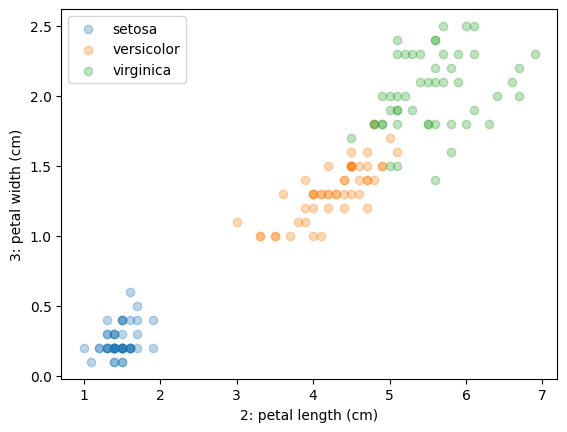

In [4]:
import matplotlib.pyplot as plt
i, j = 2, 3
plt.xlabel(f"{i}: {dataset.feature_names[i]}")
plt.ylabel(f"{j}: {dataset.feature_names[j]}")
for k in set(y):
  plt.scatter(X[y==k, i], X[y==k, j], label=dataset.target_names[k], alpha=0.3)
plt.legend()
plt.show()

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from collections import Counter
import numpy as np

def maisFrequente(y):
  counter = Counter(y)
  maisFreq = counter.most_common(1)[0][0]
  return maisFreq

class ZeroR(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.maisFreq = maisFrequente(y)
    return
  def predict(self, X):
    y = np.empty(X.shape[0], dtype=np.int64)
    y.fill(self.maisFreq)
    return y

modelo = ZeroR()
modelo.fit(X, y)
ypred = modelo.predict(X)
print(accuracy_score(y, ypred))
results = cross_validate(ZeroR(), X, y)
results['test_score'], np.mean(results['test_score'])

0.3333333333333333


(array([0.33333333, 0.33333333, 0.33333333, 0.33333333, 0.33333333]),
 0.3333333333333333)

In [11]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica_do_no = 2
    self.valor_do_no = np.mean(X[:, self.caracteristica_do_no])
    valores_maiores = X[:, self.caracteristica_do_no] > self.valor_do_no
    if sum(valores_maiores)>0 and sum(~valores_maiores)>0:
      self.arvore_de_exemplos_maiores = Arvore()
      self.arvore_de_exemplos_maiores.fit(X[valores_maiores], y[valores_maiores])
      self.arvore_de_exemplos_menores = Arvore()
      self.arvore_de_exemplos_menores.fit(X[~valores_maiores], y[~valores_maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X):
    y = np.empty(X.shape[0], dtype=np.int64)
    if hasattr(self, 'resposta'):
      y.fill(self.resposta)
    else:
      valores_maiores = X[:, self.caracteristica_do_no] > self.valor_do_no
      y[valores_maiores] = self.arvore_de_exemplos_maiores.predict(X[valores_maiores])
      y[~valores_maiores] = self.arvore_de_exemplos_menores.predict(X[~valores_maiores])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
print(accuracy_score(y, ypred))
results = cross_validate(Arvore(), X, y)
results['test_score'], np.mean(results['test_score'])

0.9533333333333334


(array([0.93333333, 0.93333333, 0.8       , 0.93333333, 1.        ]),
 0.9200000000000002)

In [12]:
def impureza(y): #Gini
  labels = list(set(y))
  labels.sort()
  probabilidades = np.zeros((len(labels),))
  for i in range(len(labels)):
    probabilidades[i] = sum(y==labels[i])/len(y)
  result = 1 - sum(probabilidades**2)
  return result

ytmp = y[:]
valor = impureza(ytmp)
print(valor)

0.6666666666666667


In [20]:
def impurezaValor(x, y, valor):
  maiores = x > valor
  impurezaMaiores = impureza(y[maiores])
  impurezaMenores = impureza(y[~maiores])
  propMaiores = sum(maiores)/len(y)
  propMenores = sum(~maiores)/len(y)
  impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
  return impurezaTotal, impurezaMaiores, impurezaMenores

print(impurezaValor(X[:,2], y, 3.5))

(0.3763955342902712, 0.4986149584487536, 0.16528925619834722)


In [21]:
def melhorValor(x, y):
  result = None
  menorImpureza = float('inf')
  xmax = np.max(x)
  xmin = np.min(x)
  while True:
    valor = (xmax+xmin)/2
    impurezaTotal, impurezaMaiores, impurezaMenores = impurezaValor(x, y, valor)
    if impurezaTotal < menorImpureza:
      menorImpureza = impurezaTotal
      result = valor
      if impurezaMaiores == 0 or impurezaMenores == 0:
        break
      if impurezaMaiores < impurezaMenores:
        xmin = valor
      else:
        xmax = valor
    else:
      break
  return result, menorImpureza

melhorValor(X[:,2], y)

(2.475, 0.3333333333333333)

In [24]:
def impurezaMinima(X, y):
  impurezas = []
  caracteristicaValores = []
  for i in range(X.shape[1]):
    valor, impurezaValor = melhorValor(X[:,i], y)
    caracteristicaValores.append([i, valor])
    impurezas.append(impurezaValor)
  caracteristicaValores = np.array(caracteristicaValores)
  impurezas = np.array(impurezas)
  indiceMenorImpureza = np.argmin(impurezas)
  caracteristica, valor = caracteristicaValores[indiceMenorImpureza]
  return int(caracteristica), valor

impurezaMinima(X, y)

(2, 2.475)

In [25]:
class Arvore(BaseEstimator, ClassifierMixin):
  def fit(self, X, y):
    self.caracteristica_do_no, self.valor_do_no = impurezaMinima(X, y)
    valores_maiores = X[:, self.caracteristica_do_no] > self.valor_do_no
    if sum(valores_maiores)>0 and sum(~valores_maiores)>0:
      self.arvore_de_exemplos_maiores = Arvore()
      self.arvore_de_exemplos_maiores.fit(X[valores_maiores], y[valores_maiores])
      self.arvore_de_exemplos_menores = Arvore()
      self.arvore_de_exemplos_menores.fit(X[~valores_maiores], y[~valores_maiores])
    else:
      self.resposta = maisFrequente(y)
    return self
  def predict(self, X):
    y = np.empty(X.shape[0], dtype=np.int64)
    if hasattr(self, 'resposta'):
      y.fill(self.resposta)
    else:
      valores_maiores = X[:, self.caracteristica_do_no] > self.valor_do_no
      y[valores_maiores] = self.arvore_de_exemplos_maiores.predict(X[valores_maiores])
      y[~valores_maiores] = self.arvore_de_exemplos_menores.predict(X[~valores_maiores])
    return y

modelo = Arvore()
modelo.fit(X, y)
ypred = modelo.predict(X)
print(accuracy_score(y, ypred))
results = cross_validate(Arvore(), X, y)
results['test_score'], np.mean(results['test_score'])

1.0


(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)

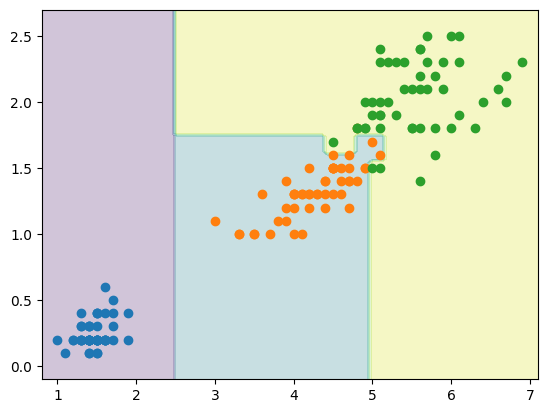

In [31]:
def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{dataset.target_names[k]} [{k}]")
    plt.show()

plotDecisao(Arvore(), X[:,2:], y)